# **Bài tập lớn Machine Learning**
 Học phần: INT3405_1

 Họ tên: Lê Thu Trang

 MSSV:18021295

# **Mô tả bài toán:**
    Dự đoán giá sản phẩm
*     Input: Dữ liệu bao gồm: tên, tình trạng sản phẩm, nhãn hiệu,vận chuyển,danh mục,mô tả.
*     Output: giá của sản phẩm(price > 0)

In [ ]:
import pandas as pd  
import numpy as np   
import urllib       
import re           
import datetime     
import calendar     
import time         
import scipy         
from sklearn.cluster import KMeans 
from haversine import haversine 
import math          
import seaborn as sns 
import matplotlib.pyplot as plt
import os    
import nltk
from nltk.corpus import stopwords
import string
import xgboost as xgb
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble, metrics, model_selection, naive_bayes
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# **Load dữ liệu**

In [ ]:
!apt-get install p7zip
!apt install --assume-yes p7zip-full
!7z x /kaggle/input/mercari-price-suggestion-challenge/train.tsv.7z -y
!7z x /kaggle/input/mercari-price-suggestion-challenge/test_stg2.tsv.zip -y

In [ ]:
train_df = pd.read_table("train.tsv")
print(train_df.shape)
train_df.head(10)

In [ ]:
test_df = pd.read_table("test_stg2.tsv")
print(test_df.shape)
test_df.head(10)

In [ ]:
train_df.nunique()

**Một sản phẩm gồm các thuộc tính:**
* name: tên của sản phẩm
* item_condition_id: tình trạng sản phẩm (1,2,3,4,5)
* category_name: danh sách danh mục sản phẩm
* brand_name: tên thương hiệu
* price: giá sản phẩm (không có trong test_stg2.tsv - đây là output của bài toán)
* shipping: 1 nếu người bán chịu phí vận chuyển, 0 nếu người mua chịu
* item_description: mô tả sản phẩm

# **Phân tích dữ liệu**

**1. item_condition_id**

In [ ]:
print("Train dataset:\n" + str(train_df['item_condition_id'].value_counts() / train_df.shape[0]))
print('item_condition_id is null:', train_df['item_condition_id'].isnull().sum())
print("\nTest dataset:\n" + str(test_df['item_condition_id'].value_counts() / test_df.shape[0]))
print('item_condition_id is null:', test_df['item_condition_id'].isnull().sum())

Các giá trị item_condition_id trên tập train và test có tỷ lệ tương đồng, tất cả các sản phẩm đều có giá trị item_condition_id

**2. category_name**

In [ ]:
print(train_df['category_name'].nunique())
train_df['category_name'].isnull().sum()

Có tất cả 1287 giá trị category khác nhau trên tập huấn luyện. Các giá trị của items trong cột category tạo nên từ 3 category riêng(1 main, 2 sub). Bên cạnh đó cũng tồn tại 6327 items không có giá trị category.

In [ ]:
print('Top 5 popular category in Train dataset\n')
train_df['category_name'].value_counts()[:5]


In [ ]:
print('Top 5 popular category in Test dataset\n')
test_df['category_name'].value_counts()[:5]


Top 5 các category phổ biến ở tập train và tập test tương tự nhau, các ngành hàng thuộc woman và beauty chiếm số lượng lớn

**3. brand_name**

In [ ]:
print(train_df['brand_name'].nunique())
print(train_df['brand_name'].isnull().sum())

Có 4809 giá trị khác nhau của brand_name trong tập train. Và có 632682 sản phẩm không có thương hiệu

In [ ]:
print("Train dataset: \n" + str(train_df['brand_name'].value_counts()[:5]))
print("\nTest dataset: \n" + str(test_df['brand_name'].value_counts()[:5]))

**4.price**

In [ ]:
train_df.price.describe()

Giá trị trung bình của trainning set là 267, nhưng giá trị một số giá trị cự trị trên 100, giá trị lớn nhất là 2000, phân bố này số lệch nhiều về bên trái

In [ ]:
plt.subplot(1, 2, 1)
(train_df['price']).plot.hist(bins=50, figsize=(20,10), edgecolor='white',range=[0,250])
plt.xlabel('price+', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.tick_params(labelsize=15)
plt.title('Price Distribution - Train Dataset', fontsize=17)

 sử dụng hàm đồng biến log() sẽ đưa đồ thị giá về gần dạng phân bố chuẩn.

In [ ]:
plt.subplot(1, 2, 2)
np.log(train_df['price']+1).plot.hist(bins=50, figsize=(20,10), edgecolor='white')
plt.xlabel('log(price+1)', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.tick_params(labelsize=15)
plt.title('Log(Price) Distribution - Train Dataset', fontsize=17)
plt.show()

**5. shipping**

In [ ]:
names='shipByBuyer', 'shipBySeller'
values=train_df.shipping.value_counts()/len(train_df)*100
plt.pie(values, labels=names,autopct='%1.1f%%',labeldistance=1.15, wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' });
plt.show();

In [ ]:
names='shipByBuyer', 'shipBySeller'
values=test_df.shipping.value_counts()/len(test_df)*100
plt.pie(values, labels=names,autopct='%1.1f%%',labeldistance=1.15, wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' });
plt.show();

55% người mua phải chịu phí vận chuyển

# **Xử lý dữ liệu**

**1.** hàm giúp xử lý tách trường category thành 3 category đơn lẻ, và các items không có nhãn sẽ được thay ("Other","Other","Other").

In [ ]:
def cat_split(text):
    try: return text.split("/")
    except: return ("Other","Other","Other")
train_df["cat_1"], train_df["cat_2"], train_df["cat_3"] = zip(*train_df["category_name"].apply(lambda cat: cat_split(cat)))
test_df["cat_1"], test_df["cat_2"], test_df["cat_3"] = zip(*test_df["category_name"].apply(lambda cat: cat_split(cat)))

**2**. Thay thế các giá trị null ở các cột category_name,brand_name, item_description

In [ ]:
def fill(data):
    data['category_name'].fillna('Missing', inplace = True)
    data['brand_name'].fillna('Missing', inplace = True)
    data['item_description'].fillna(value="None", inplace=True)
    return data

fill(train_df)
fill(test_df)

In [ ]:
#train_df.drop(columns =["category_name"], inplace = True)
train_df.drop(columns =["train_id"], inplace = True)
train_df.head()

* Do các nhãn các nhãn của các trường cat_1, cat_2, cat_3, name, brand_name, item_describtion là dạng text chiếm không gian lưu trữ, tốn bộ nhớ nên ta sẽ mã hóa các nhãn này thành dạng số bằng cách sử dụng LabeEncoder.
* LabeEncoder là là một lớp tiện ích để giúp chuẩn hóa các nhãn sao cho chúng chỉ chứa các giá trị từ 0 đến n_classes-1. Nó cũng có thể được sử dụng để chuyển đổi các nhãn không phải số (miễn là chúng có thể băm và có thể so sánh được) thành các nhãn số.

In [ ]:
cat_col=train_df.select_dtypes(include=['object']).columns.tolist()
cat_col

In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder_X=LabelEncoder()
for col in cat_col:
    train_df[col] = labelencoder_X.fit_transform(train_df[col])
train_df[cat_col].head()

In [ ]:
cat_col=test_df.select_dtypes(include=['object']).columns.tolist()
cat_col

In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder_X=LabelEncoder()
for col in cat_col:
    test_df[col] = labelencoder_X.fit_transform(test_df[col])
test_df[cat_col].head()

# **Train**

Loại bỏ các cột không cần thiết cho việc traing

In [ ]:
do_not_use_for_training = ['cat_1','test_id',"name",'cat_2','cat_3','train_id', 'category_name', 'price', 'item_description']
feature_names = [f for f in train_df.columns if f not in do_not_use_for_training]

Đổi giá sang dạng log

In [ ]:
y = np.log(train_df['price'].values + 1)

In [ ]:
from sklearn.model_selection import train_test_split
Xtr, Xv, ytr, yv = train_test_split(train_df[feature_names].values, y, test_size=0.2, random_state=0)

# **Model**

Chia tập dữ liệu huấn thành 2: huấn luyện, đánh giá: dùng để huấn luyện, đánh giá mô hình. Vì bài toán giờ đã trở thành dự đoán log() và hàm đánh giá của kaggle là Root Mean Squared Log Error(RMLSE).

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
def rmsle(Y, Y_pred):
    assert Y.shape == Y_pred.shape
    return np.sqrt(np.mean(np.square(Y_pred - Y )))

In [ ]:
def run_model(model, Xtr, ytr, Xv, yv):
    model.fit(Xtr, ytr)
    
    ypre = model.predict(Xv)
    
    mse = mean_squared_error(yv, ypre)
    r_sq = r2_score(yv, ypre)
    rmlse_1 = rmsle(yv, ypre)
    
    print("Mean Squared Error Value : "+"{:.2f}".format(mse))
    print("\nR-Squared Value : "+"{:.2f}".format(r_sq))
    print("\nRMLSE : "+"{:.2f}".format(rmlse_1))
    return model, mse, r_sq, rmlse_1

**XGBoost**

XGBoost (eXtreme Gradient Boosting) là một thuật toán học máy tập trung vào tốc độ tính toán và hiệu suất mô hình. Thuật toán có thể được sử dụng cho cả nhiệm vụ hồi quy và phân loại và được thiết kế để hoạt động với các bộ dữ liệu lớn và phức tạp.
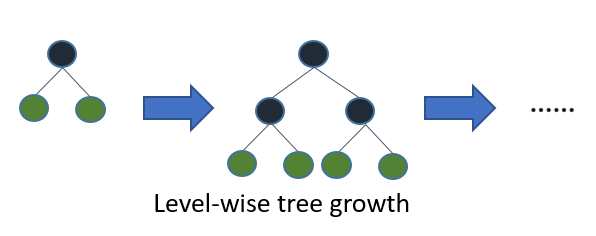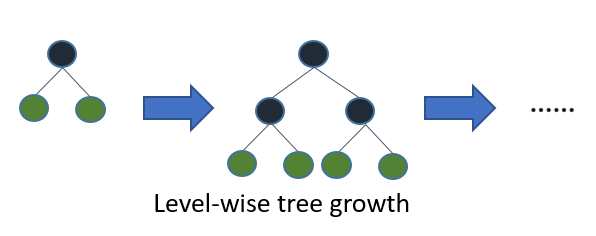

Ta chuyển các tập dữ liệu thành ma trận dữ liệu DMatrix, được sử dụng nội bộ trong XGBoost được tối ưu hóa cho cả hiệu quả bộ nhớ và tốc độ đào tạo

In [ ]:
dtrain = xgb.DMatrix(Xtr, label=ytr)
dvalid = xgb.DMatrix(Xv, label=yv)
dtest = xgb.DMatrix(test_df[feature_names].values)

In [ ]:
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

Trước khi chạy xgboost, ta cần cài đặt các thông số: thông số chung(General parameters), thông số tăng số(Booster parameters), thông số nhiệm vụ(Task parameters).

* Thông số chung:
    * booster: sử dụng gbtree
    * nthread: Số luồng song song được sử dụng để chạy XGBoost
* Thông số tree booster:
    * eat: là learning rate (0.9)
    * max_depth: Độ sâu của cây, việc tăng giá trị này sẽ làm cho mô hình phức tạp hơn và có nhiều khả năng bị quá tải (15)
    * min_child_weight: Tổng trọng lượng cá thể tối thiểu (hessian) cần thiết ở child. Trong đây sử dụng hồi quy tuyến tính, tương ứng với số lượng cá thể tối thiểu cần có trong mỗi nút. (20)
    * lamda: trọng số, tăng giá trị này sẽ làm cho mô hình trở nên thận trọng hơn (2.0)
* Thông số nhiệm vụ
    * eval_metric: Các chỉ số đánh giá cho dữ liệu xác thực (rmlse)
    * objective: mục tiêu học tập ("reg":"squarederror": hồi quy với tổn thất bình phương)
    * n_estimators: Number of gradient boosted trees. Equivalent to number of boosting rounds.(200)

In [ ]:
xgb_par = {'min_child_weight': 50, 'eta': 0.05, 'colsample_bytree': 0.5, 'max_depth': 50,
            'subsample': 0.9, 'lambda': 2.0, 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

model_1 = xgb.train(xgb_par, dtrain, 200, watchlist, early_stopping_rounds=20, maximize=False, verbose_eval=20)
print('Modeling RMSLE %.5f' % model_1.best_score)

**LinearRegression**

Linear Regression được sử dụng để phân tích dự đoán. Hồi quy tuyến tính là một cách tiếp cận tuyến tính để mô hình hóa mối quan hệ giữa tiêu chí hoặc phản ứng vô hướng và nhiều yếu tố dự báo hoặc biến giải thích. Hồi quy tuyến tính tập trung vào phân phối xác suất có điều kiện của phản hồi cho các giá trị của các yếu tố dự đoán. Đối với hồi quy tuyến tính, có nguy cơ trang bị quá mức. Công thức của hồi quy tuyến tính là: Y = bX + A.

In [ ]:
from sklearn.linear_model import LinearRegression
linear_reg = LinearRegression()
print("Linear Regression")
print("----------------")
model_2, mse_2, r_sq_2, rmlse_3 = run_model(linear_reg, Xtr, ytr, Xv, yv)

**RESULT**

Linear Regression
----------------
Mean Squared Error Value : 0.53

R-Squared Value : 0.06

RMLSE : 0.73

**Ridge Regression**
Ridge Regression là một kỹ thuật để phân tích dữ liệu hồi quy nhiều lần. Khi xảy ra đa cộng tuyến, các ước lượng bình phương nhỏ nhất là không chệch. Một mức độ chệch được thêm vào các ước tính hồi quy và kết quả là hồi quy sườn núi làm giảm các sai số tiêu chuẩn. Công thức:
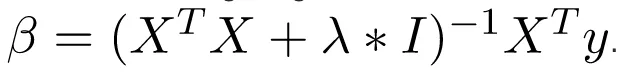!

In [ ]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge()
print("Ridge Regression")
print("----------------")
model_3, mse_3, r_sq_3, rmlse_3 = run_model(ridge_reg, Xtr, ytr, Xv, yv)

**RESULT**

Ridge Regression
----------------
Mean Squared Error Value : 0.53

R-Squared Value : 0.06

RMLSE : 0.73

**LGBM Regression**

LightGBM thực hiện sự phát triển theo chiều dọc của lá, dẫn đến giảm tổn thất nhiều hơn và do đó độ chính xác cao hơn đồng thời nhanh hơn. Nhưng điều này cũng có thể dẫn đến việc trang bị quá nhiều dữ liệu đào tạo được xử lý bằng cách sử dụng tham số độ sâu tối đa chỉ định nơi sẽ xảy ra sự phân tách. Do đó, XGBoost có khả năng xây dựng các mô hình mạnh mẽ hơn LightGBM.
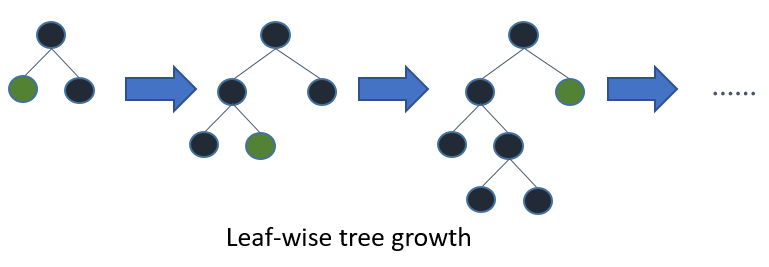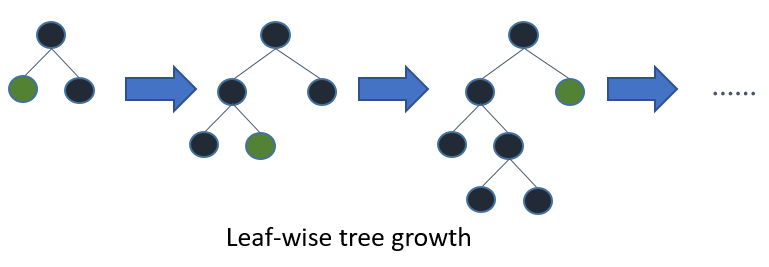

In [ ]:
import lightgbm
lgbm_reg = lightgbm.LGBMRegressor()
print("LGBM Regression")
print("---------------")
model_4, mse_4, r_sq_4, rmlse_4 = run_model(lgbm_reg, Xtr, ytr, Xv, yv)

**RESULT**

LGBM Regression
---------------
Mean Squared Error Value : 0.43

R-Squared Value : 0.23

RMLSE : 0.65

# **Submit**

In [ ]:
ytest = model_1.predict(dtest)

In [ ]:
submission = np.exp(ytest) - 1

In [ ]:
submission = pd.DataFrame(submission).reset_index()

In [ ]:
submission.columns=["test_id","price"]

In [ ]:
print(submission.shape)
submission.head()

In [ ]:
submission.to_csv('submission.csv', index=False)